In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Reshape, Conv2D, Conv1D
from tensorflow.keras import models
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
import os
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
image_size = 224
batch_size = 16
learning_rate = 0.0001
epochs_num = 50
decay = learning_rate / epochs_num

## 데이터 로드

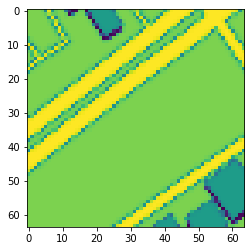

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL.Image as pilimg
import PIL
import pathlib

label_list = [ ]
image_list = [ ]

def append_image_and_label(path, label):
    file_list = os.listdir(path)
    import random
    random.seed(a=1014) 
    file_list = random.sample(file_list, k=10000)
    for filename in file_list:
        filename = path + '\\' + filename
        tfimage = tf.image.decode_png(tf.io.read_file(filename), channels=1)
        # tfimage = tf.image.central_crop(tfimage, 0.5)
        tfimage = tf.image.resize(tfimage, size=[image_size, image_size])
        tfimage = tf.cast(tfimage/255., tf.float32)
        image_list.append(tfimage)
        label_list.append(label)

append_image_and_label('D:\\1_SW2\\data\\foilum-image_20_18\\png_512', 1)
append_image_and_label('D:\\1_SW2\\data\\foilum-image_2_18\\png_512', 0)
plt.imshow(image_list[10])

In [4]:
import random
data_zip = list(zip(image_list, label_list))
random.shuffle(data_zip)
image_list, label_list =zip(*data_zip)
image_list = list(image_list)
label_list = list(label_list)


In [5]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import PIL.Image as pilimg
# import PIL
# import pathlib
# import pandas as pd
# image_data_path = '../data/for_cnn/images'
# label_data_path = '../data/for_cnn/lon_lat_list.csv'

# label_csv = pd.read_csv(label_data_path, encoding='cp949', index_col=0, header=0, engine='python')
# label_list = [ ]
# image_list = [ ]
# # https://seing.tistory.com/160
# label_csv = label_csv.sample(n=20000, # or equivalently: frac=2
#                                  replace=False, # random sampling with replacement
#                                  random_state=1024)
# label_max = label_csv['위험도'].max()
# label_min = label_csv['위험도'].min()

# for index, row in label_csv.iterrows():
#     idx = int(row["index"])
#     filename = f'{image_data_path}/{idx}.png'
#     tfimage = tf.image.decode_png(tf.io.read_file(filename), channels=1)
#     tfimage = tf.image.central_crop(tfimage, 0.5)
#     tfimage = tf.image.resize(tfimage, size=[image_size, image_size])
#     tfimage = tf.cast(tfimage/255., tf.float32)
#     #이미지 자르기 - tf.image.central_crop(image, central_fraction=0.5)
#     image_list.append(tfimage)
#     if row['위험도'] == 0.0:
#         label_list.append(0)
#     else:
#         label_list.append(1)
    
# plt.imshow(image_list[4])
# import random
# data_zip = list(zip(image_list, label_list))
# print(image_list[0])
# random.shuffle(data_zip)
# image_list, label_list = zip(*data_zip)
# print("-----")
# print(image_list[0])

In [5]:
num = len(image_list)
train_image_data = image_list[:int(num*0.8)]
train_label = label_list[:int(num*0.8)]
val_image_data = image_list[int(num*0.8): int(num*0.9)]
val_label = label_list[int(num*0.8): int(num*0.9)]
test_image_data = image_list[int(num*0.9):]
test_label = label_list[int(num*0.9):]

train_ds = tf.data.Dataset.from_tensor_slices((train_image_data, train_label))\
                          .shuffle(1024, reshuffle_each_iteration=True)\
                          .batch(batch_size, drop_remainder=True)\
                          .repeat()\
                          .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_image_data, val_label))\
                        .batch(batch_size)\
                        .repeat()\
                        .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_image_data, test_label))

## 모델 학습

In [19]:
initializer = tf.keras.initializers.HeNormal()


filter_num = 32
padding = 'valid'
bias = False
kernel_size = (3, 3)
model2 = models.Sequential([
  # input Nx17x4x3
  tf.keras.layers.Input(shape=[image_size, image_size, 1]),

  tf.keras.layers.Conv2D(filters = filter_num, kernel_size = kernel_size,  strides=1, padding='same', use_bias=bias,kernel_initializer=initializer),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  # tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(filters = filter_num*2, kernel_size = kernel_size,  strides=1, padding='same', use_bias=bias,kernel_initializer=initializer),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  # tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(filters = filter_num*4, kernel_size = kernel_size,  strides=1, padding='same', use_bias=bias,kernel_initializer=initializer),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  # tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
  # tf.keras.layers.Dropout(0.2),
  # tf.keras.layers.Conv2D(filters = filter_num*8, kernel_size = kernel_size,  strides=1, padding='same', use_bias=bias,kernel_initializer=initializer),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.ReLU(),

  # tf.keras.layers.Conv2D(filters = filter_num*8, kernel_size = kernel_size,  strides=1, padding='same', use_bias=bias,kernel_initializer=initializer),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.ReLU(),
  
  # tf.keras.layers.Conv2D(filters = filter_num*8, kernel_size = kernel_size,  strides=1, padding='same', use_bias=bias,kernel_initializer=initializer),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.ReLU(),
  # tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  # tf.keras.layers.Dense(filter_num*8, kernel_initializer=initializer, activation = 'relu'),
  # tf.keras.layers.Dense(filter_num*4, kernel_initializer=initializer, activation = 'relu'),
  tf.keras.layers.Dense(1,kernel_initializer=initializer, activation = 'sigmoid'),
])
model2.summary()
# model2.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) adadelta
# optim =  tf.keras.optimizers.Nadam()
model2.compile(optimizer= 'sgd', loss = 'binary_crossentropy', metrics=['accuracy'])

# model2.compile(optimizer= tf.keras.optimizers.Nadam(learning_rate=learning_rate),loss='mse', metrics=['mae'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 64, 64, 32)        288       
                                                                 
 batch_normalization_21 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 re_lu_21 (ReLU)             (None, 64, 64, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 64, 64, 64)        18432     
                                                                 
 batch_normalization_22 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 re_lu_22 (ReLU)             (None, 64, 64, 64)       

In [10]:
checkpoint_path = "./training_new_mp2/cp-{epoch:04d}.ckpt"   # 3
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                #  period=5,
                                                 monitor='val_accuracy',
                                                mode='max',
                                                 save_best_only=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
#                                                 patience=5, min_lr=0.00001)

In [20]:
train_num = len(train_image_data)
val_num = len(val_image_data)
steps_per_epoch = train_num// batch_size
val_steps = int(np.ceil(val_num/batch_size))


history = model2.fit(train_ds,
                     steps_per_epoch=steps_per_epoch,
                     epochs = epochs_num,
                     validation_data= val_ds, 
                     validation_steps=val_steps,
                     callbacks=[cp_callback ])

Epoch 1/50
1797/1800 [============================>.] - ETA: 0s - loss: 1.1678 - accuracy: 0.6737
Epoch 1: val_accuracy did not improve from 0.71278
1800/1800 [==============================] - 28s 15ms/step - loss: 1.1669 - accuracy: 0.6735 - val_loss: 0.6138 - val_accuracy: 0.6803
Epoch 2/50
1797/1800 [============================>.] - ETA: 0s - loss: 0.5671 - accuracy: 0.7086
Epoch 2: val_accuracy did not improve from 0.71278
1800/1800 [==============================] - 27s 15ms/step - loss: 0.5671 - accuracy: 0.7085 - val_loss: 0.7508 - val_accuracy: 0.5597
Epoch 3/50
1797/1800 [============================>.] - ETA: 0s - loss: 0.5419 - accuracy: 0.7290
Epoch 3: val_accuracy did not improve from 0.71278
1800/1800 [==============================] - 27s 15ms/step - loss: 0.5417 - accuracy: 0.7291 - val_loss: 1.1690 - val_accuracy: 0.5067
Epoch 4/50
1797/1800 [============================>.] - ETA: 0s - loss: 0.5135 - accuracy: 0.7526
Epoch 4: val_accuracy did not improve from 0.71278

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)

model2.save('./image_50.h5')
model2.save('./saved_model2/my_model2_50')

INFO:tensorflow:Assets written to: ./saved_model2/my_model2\assets


INFO:tensorflow:Assets written to: ./saved_model2/my_model2\assets


In [ ]:
model2.load_weights(latest)

model2.evaluate(np.asarray(image_list[int(num*0.8):]), np.asarray(label_list[int(num*0.8):]))


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

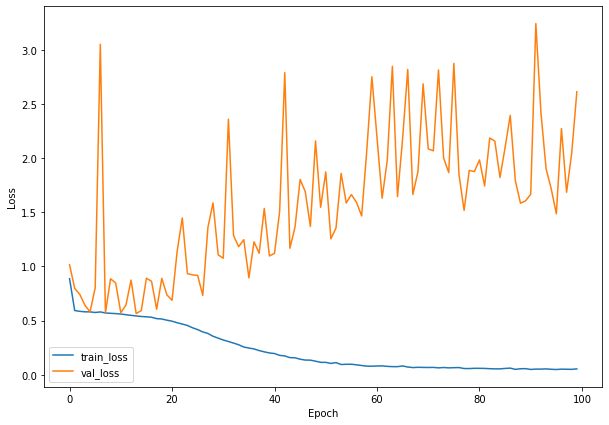

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(range(epochs_num), history.history['loss'], label='train_loss')
plt.plot(range(epochs_num), history.history['val_loss'], label='val_loss')
# history.history.keys()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()